In [1]:
! pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 1.8 MB/s eta 0:00:00


2025-05-04 20:57:38.030646: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746392258.400063      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746392258.511272      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Loading dataset...
Data loading took 3.08 seconds.
Train shape: (512, 3), Test shape: (128, 3)

Generating 7-mers...
K-mer generation took 0.16 seconds.

Extracting features using TF-IDF (max_features=None)...
TF-IDF vectorization took 1.09 seconds.
Train feature matrix shape: (512, 16384)
Test feature matrix shape: (128, 16384)

Encoding labels...
Number of classes: 128

Training LinearSVC with C=130...
Model training took 99.59 seconds.

Evaluating model on the test set...
Final F1 Score on Test Set (macro): 0.0662
Final F1 Score on Test Set (weighted): 0.0662

--- Starting Visualizations ---

Generating UMAP plot (sampling 10000 points)...


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP calculation and plotting took 9.43 seconds.


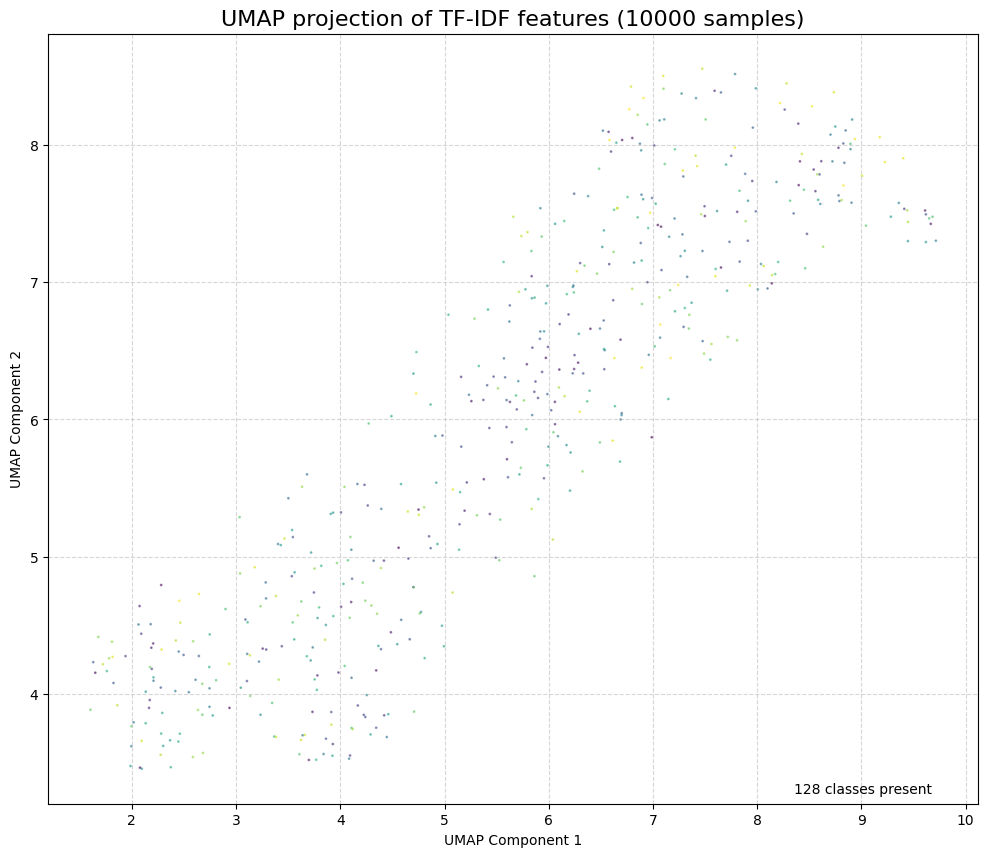


Generating Confusion Matrix heatmap...
Confusion Matrix generation took 0.35 seconds.


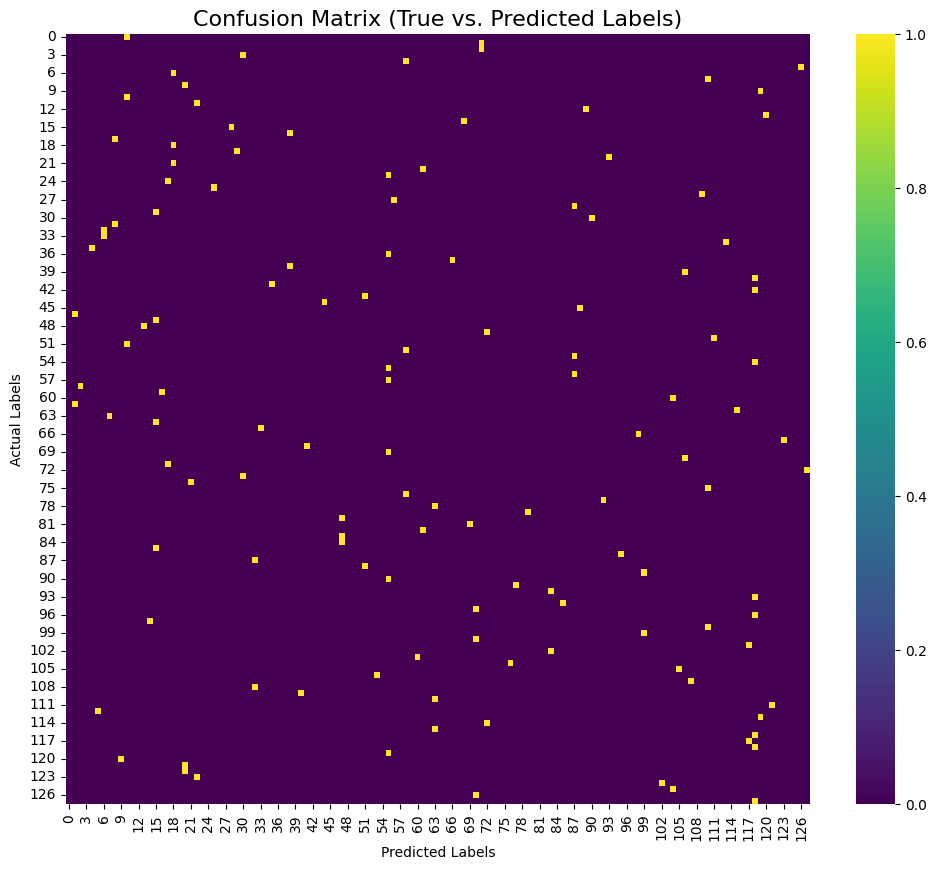


Calculating Feature Importance (Top/Bottom k-mers)...

--- Top 15 Positive/Negative k-mers for Selected Classes ---

Class: 1.14.14.18 (Index: 0)
  Top 15 Positive Features (Most Indicative):
    'tgattcc': 0.3199
    'gtacatg': 0.3125
    'atttttc': 0.2888
    'agcacgt': 0.2501
    'ttgtttg': 0.2305
    'catggta': 0.2289
    'gtgattc': 0.2288
    'gtaaagc': 0.2153
    'ctgtcac': 0.2135
    'gagaaga': 0.2135
    'tcccgat': 0.2123
    'cgtacat': 0.2115
    'aggcgca': 0.2081
    'aacgaat': 0.2070
    'gaagtag': 0.2048
  Top 15 Negative Features (Most Contra-Indicative):
    'ataataa': -0.1003
    'aaaaaaa': -0.0817
    'aataata': -0.0598
    'taaaaaa': -0.0579
    'aaagaaa': -0.0566
    'aagaaga': -0.0565
    'ttttttt': -0.0564
    'ttcttct': -0.0564
    'gcaaaaa': -0.0537
    'tcttctt': -0.0537
    'gatgaag': -0.0537
    'agcaaaa': -0.0535
    'aaaaaac': -0.0519
    'ttatttt': -0.0513
    'aaaaaat': -0.0511

Class: 1.15.1.1 (Index: 1)
  Top 15 Positive Features (Most Indicative):
    '

In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score, classification_report, confusion_matrix # Added confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
import time
import matplotlib.pyplot as plt # Added for plotting
import seaborn as sns          # Added for heatmap
import umap.umap_ as umap # Added for UMAP dimensionality reduction


# --- Configuration ---
KMER_SIZE = 7
MAX_FEATURES = None
SVM_MAX_ITER = 30000 # Increased from previous
GRID_SEARCH_CV_FOLDS = 3
N_JOBS = -1
# Config for visualizations
N_TOP_FEATURES = 15 # Number of top/bottom features to show per class
UMAP_N_NEIGHBORS = 15 # UMAP parameter (adjust based on data)
UMAP_MIN_DIST = 0.1   # UMAP parameter (adjust based on data)
UMAP_RANDOM_STATE = 42
VISUALIZATION_SAMPLE_SIZE = 10000 # Reduce data size for faster UMAP/plotting if needed, set to None for full data

# --- Step 1: Load data ---
print("Loading dataset...")
start_time = time.time()

splits = {'train': 'data/train-00000-of-00001.parquet', 'test': 'data/test-00000-of-00001.parquet'}
DATASET_NAME = "tattabio/ec_classification_dna"
df_train = pd.read_parquet(f"hf://datasets/{DATASET_NAME}/" + splits["train"])
df_test = pd.read_parquet(f"hf://datasets/{DATASET_NAME}/" + splits["test"])

print(f"Data loading took {time.time() - start_time:.2f} seconds.")
print(f"Train shape: {df_train.shape}, Test shape: {df_test.shape}")

# --- Step 2: Preprocess sequences ---
print(f"\nGenerating {KMER_SIZE}-mers...")
start_time = time.time()
def kmerize_sequence(seq, k):
    if pd.isna(seq) or len(seq) < k: return ""
    return ' '.join([seq[i:i+k] for i in range(len(seq) - k + 1)])

df_train['kmers'] = df_train['Sequence'].apply(lambda x: kmerize_sequence(x, KMER_SIZE))
df_test['kmers'] = df_test['Sequence'].apply(lambda x: kmerize_sequence(x, KMER_SIZE))
print(f"K-mer generation took {time.time() - start_time:.2f} seconds.")

# --- Step 3: Feature extraction ---
print(f"\nExtracting features using TF-IDF (max_features={MAX_FEATURES})...")
start_time = time.time()
vectorizer = TfidfVectorizer(analyzer='word', max_features=MAX_FEATURES, ngram_range=(1, 1))
X_train = vectorizer.fit_transform(df_train['kmers'])
X_test = vectorizer.transform(df_test['kmers'])
print(f"TF-IDF vectorization took {time.time() - start_time:.2f} seconds.")
print(f"Train feature matrix shape: {X_train.shape}")
print(f"Test feature matrix shape: {X_test.shape}")

# --- Step 4: Encode labels ---
print("\nEncoding labels...")
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(df_train['Label'])
y_test = label_encoder.transform(df_test['Label'])
num_classes = len(label_encoder.classes_)
print(f"Number of classes: {num_classes}")

# --- Step 5: Train Best Model (Skipping GridSearch for simplicity if C=130 is known best) ---
# Using C=130 directly as found previously. Uncomment GridSearch if needed.
best_c = 130
print(f"\nTraining LinearSVC with C={best_c}...")
start_time = time.time()
best_model = LinearSVC(
    C=best_c,
    class_weight='balanced',
    dual=False,
    max_iter=SVM_MAX_ITER,
    random_state=42
)
best_model.fit(X_train, y_train)
print(f"Model training took {time.time() - start_time:.2f} seconds.")

# --- Step 6: Evaluate on test set ---
print("\nEvaluating model on the test set...")
y_pred = best_model.predict(X_test)
f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)
f1_weighted = f1_score(y_test, y_pred, average='weighted', zero_division=0)
print(f"Final F1 Score on Test Set (macro): {f1_macro:.4f}")
print(f"Final F1 Score on Test Set (weighted): {f1_weighted:.4f}")

# --- Step 7: Visualization ---
print("\n--- Starting Visualizations ---")

# 7.1: UMAP Projection of Training Data (on a subset for speed)
if umap:
    print(f"\nGenerating UMAP plot (sampling {VISUALIZATION_SAMPLE_SIZE or 'all'} points)...")
    start_time_umap = time.time()

    # Subsample data if needed
    if VISUALIZATION_SAMPLE_SIZE and VISUALIZATION_SAMPLE_SIZE < X_train.shape[0]:
        sample_indices = np.random.choice(X_train.shape[0], VISUALIZATION_SAMPLE_SIZE, replace=False)
        X_train_sample = X_train[sample_indices]
        y_train_sample = y_train[sample_indices]
    else:
        X_train_sample = X_train
        y_train_sample = y_train

    try:
        reducer = umap.UMAP(
            n_neighbors=UMAP_N_NEIGHBORS,
            min_dist=UMAP_MIN_DIST,
            n_components=2,
            metric='cosine', # Cosine is often good for TF-IDF
            random_state=UMAP_RANDOM_STATE,
            verbose=False
        )
        embedding = reducer.fit_transform(X_train_sample)

        plt.figure(figsize=(12, 10))
        # Use a colormap suitable for many categories, like 'viridis' or 'tab20'/'tab20b' but they repeat
        # Scatter plot with small points and some transparency might be best
        scatter = plt.scatter(
            embedding[:, 0],
            embedding[:, 1],
            c=y_train_sample,
            cmap='viridis', # 'tab20' or 'nipy_spectral' might also work
            s=1, # Small points
            alpha=0.5 # Transparency
        )
        plt.title(f'UMAP projection of TF-IDF features ({VISUALIZATION_SAMPLE_SIZE or "All"} samples)', fontsize=16)
        plt.xlabel("UMAP Component 1")
        plt.ylabel("UMAP Component 2")
        # Add colorbar only if number of classes is manageable, otherwise it's useless
        if num_classes <= 30:
             plt.colorbar(scatter, label='Encoded Class Label')
        else:
             plt.text(0.95, 0.01, f'{num_classes} classes present',
                      verticalalignment='bottom', horizontalalignment='right',
                      transform=plt.gca().transAxes, fontsize=10)
        plt.grid(True, linestyle='--', alpha=0.5)
        print(f"UMAP calculation and plotting took {time.time() - start_time_umap:.2f} seconds.")
        plt.show()

    except Exception as e:
        print(f"Could not generate UMAP plot: {e}")
else:
    print("\nUMAP library not installed. Skipping UMAP plot.")


# 7.2: Confusion Matrix
print("\nGenerating Confusion Matrix heatmap...")
start_time_cm = time.time()
try:
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(12, 10)) # Adjust size as needed

    # Normalize the confusion matrix to show percentages if desired
    # cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    # sns.heatmap(cm_normalized, annot=False, cmap='viridis') # Use normalized version

    # Plotting the raw counts - may be hard to read if large
    # Decide whether to annotate based on size
    annotate_cm = cm.shape[0] <= 30 # Only annotate if fewer than ~30 classes
    sns.heatmap(cm, annot=annotate_cm, fmt='d', cmap='viridis', cbar=True) # fmt='d' for integers

    plt.title('Confusion Matrix (True vs. Predicted Labels)', fontsize=16)
    plt.ylabel('Actual Labels')
    plt.xlabel('Predicted Labels')
    # Ticks are automatically handled but might be dense if many classes
    # plt.xticks(ticks=np.arange(len(label_encoder.classes_))+0.5, labels=label_encoder.classes_, rotation=90)
    # plt.yticks(ticks=np.arange(len(label_encoder.classes_))+0.5, labels=label_encoder.classes_, rotation=0)
    print(f"Confusion Matrix generation took {time.time() - start_time_cm:.2f} seconds.")
    plt.show()
except Exception as e:
    print(f"Could not generate Confusion Matrix plot: {e}")


# 7.3: Feature Importance (Top/Bottom k-mers for selected classes)
print("\nCalculating Feature Importance (Top/Bottom k-mers)...")
try:
    coefficients = best_model.coef_
    feature_names = np.array(vectorizer.get_feature_names_out())

    # Select a few classes to inspect (e.g., first 3 or specific known classes)
    classes_to_inspect_idx = np.arange(min(5, num_classes)) # Look at first 5 classes
    classes_to_inspect_names = label_encoder.inverse_transform(classes_to_inspect_idx)

    print(f"\n--- Top {N_TOP_FEATURES} Positive/Negative k-mers for Selected Classes ---")
    for i, class_name in zip(classes_to_inspect_idx, classes_to_inspect_names):
        class_coef = coefficients[i]
        top_positive_indices = np.argsort(class_coef)[-N_TOP_FEATURES:]
        top_negative_indices = np.argsort(class_coef)[:N_TOP_FEATURES]

        top_positive_features = feature_names[top_positive_indices]
        top_positive_scores = class_coef[top_positive_indices]
        top_negative_features = feature_names[top_negative_indices]
        top_negative_scores = class_coef[top_negative_indices]

        print(f"\nClass: {class_name} (Index: {i})")
        print(f"  Top {N_TOP_FEATURES} Positive Features (Most Indicative):")
        for feature, score in zip(reversed(top_positive_features), reversed(top_positive_scores)):
            print(f"    '{feature}': {score:.4f}")
        print(f"  Top {N_TOP_FEATURES} Negative Features (Most Contra-Indicative):")
        for feature, score in zip(top_negative_features, top_negative_scores):
            print(f"    '{feature}': {score:.4f}")

except Exception as e:
    print(f"Could not calculate feature importance: {e}")


print("\n--- End of Visualizations ---")
print("--- End of Script ---")

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score, classification_report
from sklearn.preprocessing import LabelEncoder
import time
import warnings
from tqdm.auto import tqdm # For progress bar
import gc # Garbage collection

# Ignore warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)


# --- Configuration ---
MAX_SEQUENCE_LENGTH = 512 # Choose max length - smaller reduces dimensionality
SVM_MAX_ITER = 3000       # Iterations for LinearSVC
GRID_SEARCH_CV_FOLDS = 3
N_JOBS = -1

# One-Hot Encoding Mapping
# Using floats for consistency with potential downstream processing
ONE_HOT_MAP = {
    'A': np.array([1., 0., 0., 0.]),
    'C': np.array([0., 1., 0., 0.]),
    'G': np.array([0., 0., 1., 0.]),
    'T': np.array([0., 0., 0., 1.]),
    'N': np.array([0., 0., 0., 0.]) # Map N to zero vector
}
UNKNOWN_CHAR_VECTOR = np.array([0., 0., 0., 0.])
PADDING_VECTOR = np.array([0., 0., 0., 0.]) # Padding represented by zeros

# --- Step 1: Load data ---
print("Loading dataset...")
start_time = time.time()
try:
    splits = {'train': 'data/train-00000-of-00001.parquet', 'test': 'data/test-00000-of-00001.parquet'}
    DATASET_NAME = "tattabio/ec_classification_dna"
    df_train = pd.read_parquet(f"hf://datasets/{DATASET_NAME}/" + splits["train"])
    df_test = pd.read_parquet(f"hf://datasets/{DATASET_NAME}/" + splits["test"])
except Exception as e:
    print(f"Error loading data from {DATASET_NAME}: {e}")
    exit()
print(f"Data loading took {time.time() - start_time:.2f} seconds.")
print(f"Train shape: {df_train.shape}, Test shape: {df_test.shape}")

# Drop rows with missing sequences
df_train.dropna(subset=['Sequence'], inplace=True)
df_test.dropna(subset=['Sequence'], inplace=True)


# --- Step 2: One-Hot Encoding Function ---
def one_hot_encode_sequence(sequence, max_len):
    """
    Encodes a DNA sequence using one-hot mapping and pads/truncates
    to a fixed length, then flattens.
    """
    if pd.isna(sequence):
        sequence = ""

    # Ensure uppercase
    sequence = sequence.upper()

    encoded_vectors = []
    seq_len = len(sequence)

    for i in range(max_len):
        if i < seq_len:
            base = sequence[i]
            # Get the vector or use unknown vector
            vector = ONE_HOT_MAP.get(base, UNKNOWN_CHAR_VECTOR)
        else:
            # Pad with padding vector
            vector = PADDING_VECTOR
        encoded_vectors.append(vector)

    # Flatten the list of vectors into a single 1D array
    # Shape will be (max_len * 4,)
    return np.array(encoded_vectors).flatten()

# --- Step 3: Apply Encoding ---
print(f"\nApplying One-Hot Encoding (max_len={MAX_SEQUENCE_LENGTH})...")
start_time = time.time()

# Apply the function to each sequence and stack into a numpy array
# This will create a large dense array (num_samples, max_len * 4)
X_train_list = [one_hot_encode_sequence(seq, MAX_SEQUENCE_LENGTH) for seq in tqdm(df_train['Sequence'], desc="Encoding Train")]
X_train = np.vstack(X_train_list)

X_test_list = [one_hot_encode_sequence(seq, MAX_SEQUENCE_LENGTH) for seq in tqdm(df_test['Sequence'], desc="Encoding Test")]
X_test = np.vstack(X_test_list)

print(f"One-Hot Encoding took {time.time() - start_time:.2f} seconds.")
print(f"Train feature matrix shape: {X_train.shape}") # Should be (num_samples, max_len * 4)
print(f"Test feature matrix shape: {X_test.shape}")

# Clean up intermediate lists to save memory
del X_train_list, X_test_list
gc.collect()

# --- Step 4: Encode labels ---
print("\nEncoding labels...")
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(df_train['Label'])
y_test = label_encoder.transform(df_test['Label'])
num_classes = len(label_encoder.classes_)
print(f"Number of classes: {num_classes}")

# --- Step 5: Grid Search for best LinearSVM ---
# LinearSVC should still work, but the high dimensionality might affect optimal C
# Check n_features vs n_samples to inform dual setting.
n_features = X_train.shape[1]
n_samples = X_train.shape[0]
# Set dual based on recommendation (False if n_samples > n_features)
dual_setting = False if n_samples > n_features else True
print(f"\nUsing dual={dual_setting} for LinearSVC (n_samples={n_samples}, n_features={n_features})")

print("\nStarting Grid Search for LinearSVC on One-Hot Features...")
start_time = time.time()

param_grid = {
    'C': [0.025,0.026,0.027,0.028,0.029], # Test a range for C
}

svm = LinearSVC(
    class_weight='balanced',
    dual=dual_setting,
    max_iter=SVM_MAX_ITER,
    random_state=42
    )

grid_search = GridSearchCV(
    svm,
    param_grid,
    cv=GRID_SEARCH_CV_FOLDS,
    scoring='f1_macro',
    verbose=2,
    n_jobs=N_JOBS
    )

# Fit on the training data
grid_search.fit(X_train, y_train)

print(f"Grid Search took {time.time() - start_time:.2f} seconds.")
print("Best Parameters found by Grid Search:", grid_search.best_params_)
print(f"Best F1 score (macro) during CV: {grid_search.best_score_:.4f}")

# --- Step 6: Evaluate on test set ---
print("\nEvaluating best model on the test set...")
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calculate and print metrics
f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)
f1_weighted = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print(f"\n--- Final Results (One-Hot Encoding + LinearSVC) ---")
print(f"Max Sequence Length: {MAX_SEQUENCE_LENGTH}")
print(f"Feature Dimension: {X_train.shape[1]}")
print(f"Best C: {grid_search.best_params_['C']}")
print("-" * 30)
print(f"Final F1 Score on Test Set (macro): {f1_macro:.4f}")
print(f"Final F1 Score on Test Set (weighted): {f1_weighted:.4f}")
print("-" * 30)

print("\nClassification Report on Test Set:\n")
try:
    # (Optional: Add subset reporting logic if needed)
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_, zero_division=0))
except Exception as report_e:
    print(f"Could not generate full classification report: {report_e}")
    print(classification_report(y_test, y_pred, zero_division=0))

print("--- End of Script ---")

Loading dataset...
Data loading took 3.31 seconds.
Train shape: (512, 3), Test shape: (128, 3)

Applying One-Hot Encoding (max_len=512)...


Encoding Train:   0%|          | 0/512 [00:00<?, ?it/s]

Encoding Test:   0%|          | 0/128 [00:00<?, ?it/s]

One-Hot Encoding took 0.21 seconds.
Train feature matrix shape: (512, 2048)
Test feature matrix shape: (128, 2048)

Encoding labels...
Number of classes: 128

Using dual=True for LinearSVC (n_samples=512, n_features=2048)

Starting Grid Search for LinearSVC on One-Hot Features...
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Grid Search took 6.14 seconds.
Best Parameters found by Grid Search: {'C': 0.025}
Best F1 score (macro) during CV: 0.0225

Evaluating best model on the test set...

--- Final Results (One-Hot Encoding + LinearSVC) ---
Max Sequence Length: 512
Feature Dimension: 2048
Best C: 0.025
------------------------------
Final F1 Score on Test Set (macro): 0.0508
Final F1 Score on Test Set (weighted): 0.0508
------------------------------

Classification Report on Test Set:

              precision    recall  f1-score   support

  1.14.14.18       0.00      0.00      0.00         1
    1.15.1.1       0.00      0.00      0.00         1
    1.16.3.1       0.00    

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV # Added GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC # Changed import
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score
)
from itertools import product
import time
from tqdm.auto import tqdm # Added for progress bar
import warnings

# Ignore warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)


# --- Configuration ---
KMER_SIZE = 6      # K-mer length (k=4 -> 256 features)
SVM_MAX_ITER = 50000 # Max iterations for LinearSVC convergence
GRID_SEARCH_CV_FOLDS = 3
N_JOBS = -1 # Use all available CPU cores

# --- Encoding Function (Renamed for Accuracy) ---
def kmer_frequency_encode(sequences, k=3):
    """
    Encode DNA sequences using normalized k-mer frequencies (KNC).
    """
    print(f"Generating all possible {k}-mers...")
    nucleotides = ['A', 'C', 'G', 'T']
    # Handle k=0 or negative k gracefully
    if k <= 0:
        return np.array([[] for _ in sequences]) # Return empty features
        
    try:
        kmers = [''.join(p) for p in product(nucleotides, repeat=k)]
    except OverflowError: # Handle cases where 4^k is extremely large
        print(f"Error: k={k} results in too many k-mers (4^{k}). Choose a smaller k.")
        return None # Indicate failure
        
    kmer_index = {kmer: idx for idx, kmer in enumerate(kmers)}
    num_kmers = len(kmers)
    features = []
    print(f"Encoding {len(sequences)} sequences...")

    for seq in tqdm(sequences, desc=f"Encoding {k}-mers"):
        counts = np.zeros(num_kmers, dtype=float) # Use float for division later
        if pd.isna(seq) or len(seq) < k:
            features.append(counts) # Append zero vector for invalid sequences
            continue
            
        seq = seq.upper()
        total_valid_kmers = 0
        for i in range(len(seq) - k + 1):
            kmer = seq[i:i + k]
            # More robust check for valid k-mer characters
            idx = kmer_index.get(kmer) # Use .get for faster lookup and handling of non-ACGT k-mers
            if idx is not None:
                counts[idx] += 1
                total_valid_kmers += 1
                
        # Normalize counts
        if total_valid_kmers > 0:
            counts /= total_valid_kmers # In-place division
            
        features.append(counts)

    return np.array(features)


def main():
    # --- Step 1: Load data ---
    print("Loading dataset...")
    start_time_load = time.time()
    splits = {
        'train': 'data/train-00000-of-00001.parquet',
        'test': 'data/test-00000-of-00001.parquet'
    }
    DATASET_NAME = "tattabio/ec_classification_dna"
    try:
        df_train = pd.read_parquet(f"hf://datasets/{DATASET_NAME}/" + splits["train"])
        df_test = pd.read_parquet(f"hf://datasets/{DATASET_NAME}/" + splits["test"])
    except Exception as e:
        print(f"Error loading data from {DATASET_NAME}: {e}")
        exit()
    print(f"Data loading took {time.time() - start_time_load:.2f} seconds.")
    print(f"Train shape: {df_train.shape}, Test shape: {df_test.shape}")
    
    # Drop rows with missing sequences
    df_train.dropna(subset=['Sequence'], inplace=True)
    df_test.dropna(subset=['Sequence'], inplace=True)

    # --- Step 2: Encode Sequences ---
    print(f"\nEncoding sequences using {KMER_SIZE}-mer frequencies (KNC)...")
    start_time_encode = time.time()
    X_train = kmer_frequency_encode(df_train['Sequence'].tolist(), k=KMER_SIZE)
    X_test = kmer_frequency_encode(df_test['Sequence'].tolist(), k=KMER_SIZE)
    
    # Handle potential encoding failure (e.g., k too large)
    if X_train is None or X_test is None:
        print("Exiting due to encoding error.")
        exit()
        
    print(f"Encoding completed in {time.time() - start_time_encode:.2f} seconds.")
    print(f"Train feature matrix shape: {X_train.shape}")
    print(f"Test feature matrix shape: {X_test.shape}")
    
    # Check if encoding produced valid features
    if X_train.shape[1] == 0:
        print("Error: Encoding resulted in zero features. Check k-mer size and sequences.")
        exit()

    # --- Step 3: Encode Labels ---
    print("\nEncoding labels...")
    le = LabelEncoder()
    y_train = le.fit_transform(df_train['Label'])
    y_test = le.transform(df_test['Label'])
    print(f"Number of classes: {len(le.classes_)}")

    # --- Step 4: Grid Search for best LinearSVC ---
    # Determine dual setting
    n_samples, n_features = X_train.shape
    dual_setting = False if n_samples > n_features else True
    print(f"\nUsing dual={dual_setting} for LinearSVC (n_samples={n_samples}, n_features={n_features})")
    
    print("\nStarting Grid Search for LinearSVC...")
    start_time_grid = time.time()
    
    param_grid = {
        'C': [144,145,146], # Example range for regularization strength
    }

    svm = LinearSVC(
        class_weight='balanced',
        dual=dual_setting,
        max_iter=SVM_MAX_ITER,
        random_state=42
    )

    grid_search = GridSearchCV(
        svm,
        param_grid,
        cv=GRID_SEARCH_CV_FOLDS,
        scoring='f1_macro', # Use macro F1 for multi-class imbalance
        verbose=2,
        n_jobs=N_JOBS # Use all available cores
    )

    # Fit GridSearchCV on the training data
    grid_search.fit(X_train, y_train)

    print(f"Grid Search took {time.time() - start_time_grid:.2f} seconds.")
    print("Best Parameters found by Grid Search:", grid_search.best_params_)
    print(f"Best F1 score (macro) during CV: {grid_search.best_score_:.4f}")

    # --- Step 5: Evaluate on test set ---
    print("\nEvaluating best model on the test set...")
    best_model = grid_search.best_estimator_ # Already refitted on the whole train set
    y_pred = best_model.predict(X_test)

    # Calculate and print metrics
    f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)
    f1_weighted = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    
    print(f"\n--- Final Results (KNC k={KMER_SIZE} + LinearSVC) ---")
    print(f"Feature Dimension: {X_train.shape[1]}")
    print(f"Best C found: {grid_search.best_params_['C']}")
    print("-" * 30)
    print(f"Final F1 Score on Test Set (macro): {f1_macro:.4f}")
    print(f"Final F1 Score on Test Set (weighted): {f1_weighted:.4f}")
    print("-" * 30)

if __name__ == "__main__":
    main()

Loading dataset...
Data loading took 1.16 seconds.
Train shape: (512, 3), Test shape: (128, 3)

Encoding sequences using 6-mer frequencies (KNC)...
Generating all possible 6-mers...
Encoding 512 sequences...


Encoding 6-mers:   0%|          | 0/512 [00:00<?, ?it/s]

Generating all possible 6-mers...
Encoding 128 sequences...


Encoding 6-mers:   0%|          | 0/128 [00:00<?, ?it/s]

Encoding completed in 0.69 seconds.
Train feature matrix shape: (512, 4096)
Test feature matrix shape: (128, 4096)

Encoding labels...
Number of classes: 128

Using dual=True for LinearSVC (n_samples=512, n_features=4096)

Starting Grid Search for LinearSVC...
Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] END ............................................C=0.026; total time=   0.9s
[CV] END ............................................C=0.027; total time=   0.9s
[CV] END ............................................C=0.028; total time=   0.9s
[CV] END ............................................C=0.029; total time=   0.6s
[CV] END ..............................................C=144; total time= 8.3min
[CV] END ..............................................C=146; total time= 7.4min
[CV] END ............................................C=0.025; total time=   0.9s
[CV] END ............................................C=0.026; total time=   0.9s
[CV] END .......................